# How to use VoronoiBoost

In [3]:
import numpy as np
import pandas as pd
import json

import random

from shapely.geometry import shape as Shape
from shapely.geometry import Point, Polygon, MultiPolygon, mapping

import folium

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colrs

from voronoiBoost import VoronoiBoost

## Load data

In [4]:
WORKING_DIR = '/home/jupyter-landy/data/voronoi2@secon/voronoiBoost'

### Load Orange BS deployment in Lyon

In [5]:
filename = f'{WORKING_DIR}/data/df_bs_Orange_Lyon.pkl'
df_bs_sites = pd.read_pickle(filename)
df_bs_sites.head(2)

,id,_lon,_lat,operator,city,location,height,owner,postal_code,outdoor,x,y,lon,lat
3871,[53555],[5.076666667],[45.614444444],Orange,LYON,[Pylône autostable],[30],[TOTEM],[37110],[True],6.365906e+06,3.196582e+06,5.076667,45.614444
3872,[102526],[4.857777778],[45.77],Orange,LYON,[Pylône autostable],[30],[TDF],[37110],[True],6.400263e+06,3.181612e+06,4.857778,45.770000


In [6]:
lons, lats = list(df_bs_sites['lon']), list(df_bs_sites['lat'])
sites = list(zip(lons, lats))

### Load cities shapes

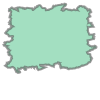

In [7]:
city_file = f'{WORKING_DIR}/data/Lyon.geojson'
fd = open(city_file, 'r')
city_json = json.load(fd)
fd.close()
city_json = city_json['features'][0]['geometry']
city_shape = Shape(city_json)
city_shape

## Run VoronoiBoost

In [8]:
model_path = f'{WORKING_DIR}/model/voronoiBoost.sav.xz'
voronoiBoost = VoronoiBoost(sites, city_shape, model_path)

df_bs = voronoiBoost.compute_voronoiBoost()
df_bs.head(2)

Computing VoronoiBoost 🤓...
Computing Voronoi Tessellation 💻...
Voronoi Tessellation successful 🤩.
Computing Delaunay Graph 💻...
Delaunay Graph computed 🤩.
Computing features 🤖...
Features computed 🤓.
Loading model 📦...
Model loaded 🤩.
Correcting scales ➕...
Scales corrected ✅.
Computing Voronois overlap 🤓...
Voronois overlap computed ✅.
VoronoiBoost computed ✅.


,id,lon,lat,voronoi,voronois_scaled_overlap
0,0,5.076667,45.614444,"POLYGON ((5.047342244951341 45.58905903865365,...",[(POLYGON ((5.052194700052437 45.5949452994652...
1,1,4.857778,45.770000,"POLYGON ((4.857074607313634 45.76744691709767,...",[(POLYGON ((4.857115303507272 45.7675503988439...


## Show results

### Legacy Tessallation

In [13]:
df_bs_sample = df_bs.sample(frac=.1)

In [17]:
lon, lat = city_shape.centroid.x, city_shape.centroid.y

m = folium.Map(location=[lat, lon], zoom_control=True, zoom_start=10, 
                    tiles='https://api.mapbox.com/styles/v1/mapbox/light-v9/tiles/{z}/{x}/{y}?access_token=pk.eyJ1IjoibGFuZHlzIiwiYSI6ImNraHFjeXA1NzA1ZzkycW11cjl3dnpyMnAifQ.7mSkfJjaSfJXoGBxa_rg1g', attr='Mapbox')

folium.GeoJson(
    city_shape,
    style_function=lambda feature: {
    'fillColor': 'green',
    'color': 'green',
    'fillOpacity': 0,
    'opacity': .5,
    'width' : .1,
}).add_to(m)


for bs in df_bs_sample.to_dict(orient='records'):
    bs_id = bs['id']
    lat, lon = bs['lat'], bs['lon']
    legacy_voronoi = bs['voronoi']

    folium.Polygon([[(point[1], point[0]) for point in mapping(legacy_voronoi)['coordinates'][0]]],
        color='lightblue',
        opacity = 1,
        fill_opacity = 0,
        width=.1,
        ).add_to(m)

    folium.Circle(
        radius=20,
        location=[lat, lon],
        color='green',
        fill_color='green',
        opacity=.5,
        fill_opacity=.5,
        tooltip=f'BS {bs_id}',
        popup=f'<input type=text value="{lat},{lon}">',
    ).add_to(m)

m

### Show results overlap (fraction)

In [18]:
cmaps = ['Reds', 'Greens', 'Blues', 'Purples', 'Oranges', 'Greys']

In [21]:
lon, lat = city_shape.centroid.x, city_shape.centroid.y
m = folium.Map(location=[lat, lon], zoom_control=True, zoom_start=10, 
                    tiles='https://api.mapbox.com/styles/v1/mapbox/light-v9/tiles/{z}/{x}/{y}?access_token=pk.eyJ1IjoibGFuZHlzIiwiYSI6ImNraHFjeXA1NzA1ZzkycW11cjl3dnpyMnAifQ.7mSkfJjaSfJXoGBxa_rg1g', attr='Mapbox')

folium.GeoJson(
    city_shape,
    style_function=lambda feature: {
    'fillColor': 'green',
    'color': 'green',
    'fillOpacity': 0,
    'opacity': .5,
    'width' : .1,
}).add_to(m)


for bs in df_bs_sample.to_dict(orient='records'):
    lat, lon = bs['lat'], bs['lon']
    voronoiboost = bs['voronois_scaled_overlap']
    
    cmap = cmaps[random.randint(0, len(cmaps)-1)]
    my_cmap = plt.cm.get_cmap(cmap)
    norm = colrs.Normalize(vmin=0,  vmax=1)
    
    for voronoi, tau in voronoiboost:

        if voronoi.type != 'Polygon':
            continue

        color = colrs.to_hex(my_cmap(norm(tau)))

        folium.Polygon([[(point[1], point[0]) for point in mapping(voronoi)['coordinates'][0]]],
            color=color,
            fill_color=color,
            opacity = .1,
            fill_opacity = .1,
            width=.1,
            ).add_to(m)

    folium.Circle(
        radius=20,
        location=[lat, lon],
        color=color,
        fill_color=color,
        opacity=.5,
        full_opacity=.5,
        tooltip=f'BS {bs_id}',
        popup=f'<input type=text value="{lat},{lon}">',
    ).add_to(m)

m